In [1]:
# Mount on Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install advertorch

     |████████████████████████████████| 5.7MB 9.4MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=6872795612fa0402857375302afdf40266311eb49a4a1776929a238367a94f9b
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [3]:
# Going to my directory

%cd /content/gdrive/My Drive/Colab Notebooks/projectsml


/content/gdrive/My Drive/Colab Notebooks/projectsml


In [4]:
## LIBRARIES

## Usual python tools
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import pandas as pd
## Torch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Torchvision
import torchvision
from torchvision import transforms, datasets


from advertorch.attacks import SinglePixelAttack

In [5]:
## LOAD CLASSES AND BUILD DICTIONARY

signs = pd.read_table("classes.txt", header=None, names=['Belgium signs'])

dicts = {}
for i in range(0,62):
  dicts[i] = signs['Belgium signs'][i]

print(dicts)

{0: 'uneven road', 1: 'humps', 2: 'slippery road', 3: 'bend, to left', 4: 'bend, to right', 5: 'double bend, first to left', 6: 'double bend, first to right', 7: 'children', 8: 'bicycle crossing', 9: 'cattle', 10: 'road works', 11: 'traffic lights', 12: 'level crossing with barrier', 13: 'other danger', 14: 'road narrows', 15: 'road narrows on left', 16: 'road narrows on right', 17: 'crossroads', 18: 'crossroads with right-of-way from the right', 19: 'give way', 20: 'priority from opposite direction', 21: 'stop', 22: 'no entry', 23: 'no bicycles', 24: 'max weight', 25: 'no heavy load', 26: 'max width', 27: 'max height', 28: 'traffic not allowed', 29: 'no turn left', 30: 'no turn right', 31: 'no overtaking', 32: 'max speed', 33: 'pedestrian zone', 34: 'drive straight', 35: 'turn', 36: 'drive straight or turn right', 37: 'roundabout', 38: 'bicycles only', 39: 'bicycles and pedestrians', 40: 'no parking', 41: 'no stopping on the side ', 42: 'no parking', 43: 'no parking 16-31', 44: 'prior

In [6]:
torch.manual_seed(torch.rand(1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [7]:
## SOME USEFUL FUNCTIONS

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
           
    return float(n_right) / tot

In [8]:
## TRANSFORMATIONS

data_transforms = {'Training': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ]),
                   'Testing': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ])
                   }

In [18]:
## LOADING DATA

# Location of data
data_dir = './data/'

# Load dataset
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
# Create dataloaders (test and train)
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=8, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=1, shuffle=True)}

# Save sizes and classes
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes

In [17]:
net=torchvision.models.googlenet(pretrained=True, progress=True)
net.fc=nn.Linear(net.fc.in_features,62)
net.to(device)
net.load_state_dict(torch.load("./models/64_20e.h5"), strict=False)

<All keys matched successfully>

In [11]:
#now take probabilities as arbouments
def _show_images(img, advimg, pred, advpred,probpre, probafter):
    
    perturb = advimg - img
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])

    plt.figure(figsize=(10, 8))

    plt.subplot(1, 3, 1)
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    m=nn.Softmax(0)
    plt.title("original image\n prediction: {}\n with probability: {}".format(dicts[pred],probpre))
    
    plt.subplot(1, 3, 2)
    perturb = perturb.numpy().transpose((1, 2, 0))
    perturb = std * perturb + mean
    perturb = np.clip(perturb, 0, 1)
    plt.imshow(perturb)
    plt.axis("off")
    plt.title("the perturbation")
    
    plt.subplot(1, 3, 3)
    advimg = advimg.numpy().transpose((1, 2, 0))
    advimg = std * advimg + mean
    advimg = np.clip(advimg, 0, 1)
    plt.imshow(advimg)
    plt.axis("off")
    plt.title("perturbed image\n prediction: {}\n with probability:{}".format(dicts[advpred],probafter))
    plt.show()

In [12]:
from advertorch.defenses import MedianSmoothing2D
median_filter = MedianSmoothing2D(kernel_size=5)
defense = nn.Sequential(  median_filter)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


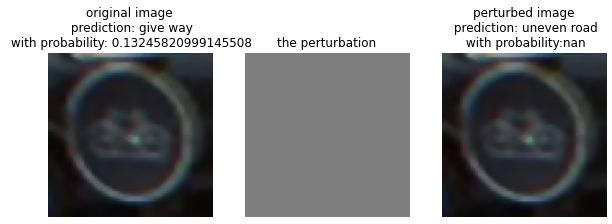

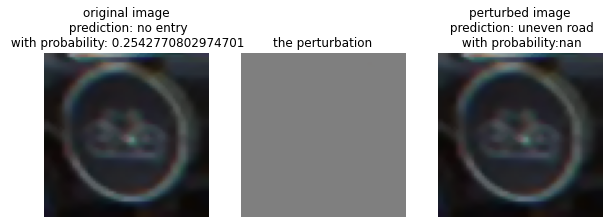

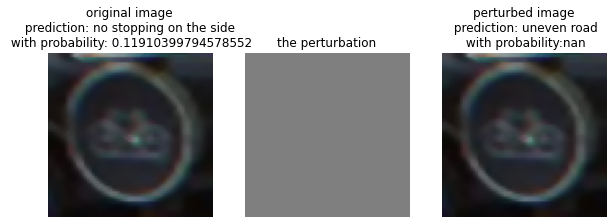

In [20]:
## single pixel Attack

x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()


m=nn.Softmax()
adversary = SinglePixelAttack(net, max_pixels=250, clip_min=-np.inf, loss_fn=None, clip_max=np.inf)

Adv_img = x
x_def=defense(x)
for _ in range(1,4):
  Adv_img = adversary.perturb(Adv_img)
  Adv_img_def=defense(Adv_img) 
  output_adv_before = net(Adv_img)
  output_img_before = net(x_)


  x_prob=m(output_img_before[0].cpu())
  probpre=max(x_prob)
  x_prob=m(output_adv_before[0].cpu())
  probpost=max(x_prob)

  _show_images(img=x_def[0].cpu().detach(),
              advimg=Adv_img_def[0].cpu().detach(),
              pred=torch.argmax(output_img_before, dim=1)[0].item(),
              advpred=torch.argmax(output_adv_before, dim=1)[0].item(),probpre=probpre,probafter=probpost)


In [14]:
## Single Pixel Attack (3 pixels, smoothing defence)
net.eval()
tot = len(dataloaders['Testing'].dataset)
j=0
correct=0

adversary = SinglePixelAttack(net, max_pixels=50, clip_min=-np.inf, loss_fn=None, clip_max=np.inf)
for data, target in dataloaders['Testing']:
    j+=1
    print("batch no",j)
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]

 
    Adv_img = adversary.perturb(data)
    Adv_img = adversary.perturb(Adv_img)
    Adv_img = adversary.perturb(Adv_img)
    # Re-classify the perturbed image
    Adv_img=defense(Adv_img)
    output = net(Adv_img)
    
    # Check for success

    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
    #if j%5==0:
      #  _show_images(data[0].cpu().detach(), Adv_img[0].cpu().detach(),target[0],final_pred[0])
    
    correct += torch.sum(target == final_pred)
print("Adversarial test Accuracy = {} / {} -> {:.2f}%".format(correct, tot, float(correct)/float(tot)*100))


batch no 1
batch no 2
batch no 3
batch no 4
batch no 5
batch no 6
batch no 7
batch no 8
batch no 9
batch no 10
batch no 11
batch no 12
batch no 13
batch no 14
batch no 15
batch no 16
batch no 17
batch no 18
batch no 19
batch no 20
batch no 21
batch no 22
batch no 23
batch no 24
batch no 25
batch no 26
batch no 27
batch no 28
batch no 29
batch no 30
batch no 31
batch no 32
batch no 33
batch no 34
batch no 35
batch no 36
batch no 37
batch no 38
batch no 39
batch no 40
Adversarial test Accuracy = 6 / 2520 -> 0.24%
